# Software Defect Detection Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import requests
from graphviz import Source
from scipy.stats import kruskal
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

BASELINE_METRICS_DATASET = 'GHPR_dataset-master/baseline.csv'
REPO_INFO_DATASET = 'GHPR_dataset-master/GHPR/ghprdata/ghprdata.csv'

REPO_INFO_TITLES = [
    'PROJECT_NAME', 'PROJECT_OWNER', 'PROJECT_DESCRIPTION', 'PROJECT_LABEL',
    'PROJECT_LANGUAGE', 'SHA_FIXED', 'SHA_BUG', 'DIFF_CODE',
    'COMMIT_DESCRIPTION', 'COMMIT_TIME', 'OLD_CONTENT', 'NEW_CONTENT',
    'OLD_PATH', 'NEW_PATH', 'PR_TITLE', 'PR_DESCRIPTION'
]

/home/pi/csc5610/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
repo_dataframe = pd.read_csv(REPO_INFO_DATASET, names=REPO_INFO_TITLES)

In [3]:
repo_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PROJECT_NAME         3026 non-null   object
 1   PROJECT_OWNER        3026 non-null   object
 2   PROJECT_DESCRIPTION  2947 non-null   object
 3   PROJECT_LABEL        2969 non-null   object
 4   PROJECT_LANGUAGE     3026 non-null   object
 5   SHA_FIXED            3026 non-null   object
 6   SHA_BUG              3026 non-null   object
 7   DIFF_CODE            3026 non-null   object
 8   COMMIT_DESCRIPTION   2298 non-null   object
 9   COMMIT_TIME          3026 non-null   int64 
 10  OLD_CONTENT          3026 non-null   object
 11  NEW_CONTENT          3026 non-null   object
 12  OLD_PATH             3026 non-null   object
 13  NEW_PATH             3026 non-null   object
 14  PR_TITLE             3022 non-null   object
 15  PR_DESCRIPTION       2298 non-null   object
dtypes: int

In [4]:
repo_dataframe.head(10)

,PROJECT_NAME,PROJECT_OWNER,PROJECT_DESCRIPTION,PROJECT_LABEL,PROJECT_LANGUAGE,SHA_FIXED,SHA_BUG,DIFF_CODE,COMMIT_DESCRIPTION,COMMIT_TIME,OLD_CONTENT,NEW_CONTENT,OLD_PATH,NEW_PATH,PR_TITLE,PR_DESCRIPTION
0,Gadgetbridge,Freeyourgadget,Github mirror of Gadgetbridge - A free and clo...,"activity post processing,activity/health,andro...",Java,000f1ab4780fc9460975791c52597f7c04e15be7,ece0f094eb56219ae5188dcd37b90590a9f4029d,diff --git a/app/src/main/java/nodomain/freeyo...,Fix duplicated DeviceType key introduced by th...,20180902,"/* Copyright (C) 2015-2018 Andreas Shimokawa,...","/* Copyright (C) 2015-2018 Andreas Shimokawa,...",app/src/main/java/nodomain/freeyourgadget/gadg...,app/src/main/java/nodomain/freeyourgadget/gadg...,Roidmi: fix duplicated DeviceType key,Fix duplicated DeviceType key introduced by th...
1,MaterialDateTimePicker,wdullaer,Pick a date or time on Android in style,"bug,duplicate,enhancement,help wanted,invalid,...",Java,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c27,288f0a9c4b01ffcedf9fec41dd7c0373ee55f277,diff --git a/library/src/main/java/com/wdullae...,No repro steps known but observed in crash rep...,20190209,/*\n * Copyright (C) 2013 The Android Open Sou...,/*\n * Copyright (C) 2013 The Android Open Sou...,library/src/main/java/com/wdullaer/materialdat...,library/src/main/java/com/wdullaer/materialdat...,NPE fix: DayPickerView accessibilityAnnouncePa...,No repro steps known but observed in crash rep...
2,processing,processing,Source code for the Processing Core and Develo...,"android,arm,arm64,book,cantfix,core,critical,d...",Java,005681edd7b222a51d6bdf64cdcba489cd617d1d,1ebf79592c9bedfca838a6e58463470dc1445b84,diff --git a/core/src/processing/core/PApplet....,A couple of Tools in the Base menu are not ren...,20140403,/* -*- mode: java; c-basic-offset: 2; indent-t...,/* -*- mode: java; c-basic-offset: 2; indent-t...,core/src/processing/core/PApplet.java,core/src/processing/core/PApplet.java,"Fix NPE in PDE, affecting color picker and oth...",A couple of Tools in the Base menu are not ren...
3,pentaho-kettle,pentaho,Pentaho Data Integration ( ETL ) a.k.a Kettle,"bug,duplicate,enhancement,invalid,question,won...",Java,005f52621571d1d0d7140e28a1ad5f629bad3bb9,982fbd18142bf5345d50a58f928b8bc7243dc8be,diff --git a/engine/src/org/pentaho/di/trans/s...,Master PR: https://github.com/pentaho/pentaho-...,20170425,/*********************************************...,/*********************************************...,engine/src/org/pentaho/di/trans/steps/textfile...,engine/src/org/pentaho/di/trans/steps/textfile...,[BACKLOG-16118] Fixed issue with field lengths...,Master PR: https://github.com/pentaho/pentaho-...
4,frontend-maven-plugin,eirslett,"""Maven-node-grunt-gulp-npm-node-plugin to end ...","bug,duplicate,enhancement,invalid,question,won...",Java,0081f8f594e3b67879370d712d35a809dd0250b4,b45e73d6cca812f4874013c4eba00f873ca43d36,diff --git a/frontend-plugin-core/src/main/jav...,because File.rename does not support overwrit...,20190312,package com.github.eirslett.maven.plugins.fron...,package com.github.eirslett.maven.plugins.fron...,frontend-plugin-core/src/main/java/com/github/...,frontend-plugin-core/src/main/java/com/github/...,Fix #670: Use Files.move instead of File.renam...,because File.rename does not support overwrit...
5,cas,apereo,Apereo CAS - Enterprise Single Sign On for all...,"AWS Cloud Directory,AWS DynamoDb,Acceptable Us...",Java,00c16dd03ad44c07088def792e7dd4583187caa3,d0024e28889e597c03a059296f35a4360c5b11e6,diff --git a/support/cas-server-support-geoloc...,NaN,20180727,package org.apereo.cas.support.geo.config;\n\n...,package org.apereo.cas.support.geo.config;\n\n...,support/cas-server-support-geolocation-maxmind...,support/cas-server-support-geolocation-maxmind...,Fix possible NPE in configuration when no db p...,NaN
6,qksms,moezbhatti,The most beautiful SMS messenger for Android,"Bug,Discussion,Easy,Enhancement,Feature,Refact...",Java,00c1e07f0575b518af4ce8e383dff92c6cf04582,fb27d745e638fb2c9e5ec930

## Column Exploration

### Repository Metadata

In [5]:
repo_dataframe['PROJECT_NAME'].value_counts()

PROJECT_NAME
libgdx                   161
BroadleafCommerce        113
Terasology               108
Mycat-Server              76
MinecraftForge            72
                        ... 
AndroidViewAnimations      1
APIJSON                    1
CircleImageView            1
SystemBarTint              1
jianshi                    1
Name: count, Length: 301, dtype: int64

In [6]:
repo_dataframe['PROJECT_OWNER'].value_counts()

PROJECT_OWNER
libgdx               161
apache               132
BroadleafCommerce    113
MovingBlocks         108
MyCATApache           76
                    ... 
rey5137                1
Skykai521              1
TommyLemon             1
hdodenhof              1
wingjay                1
Name: count, Length: 259, dtype: int64

In [7]:
repo_dataframe['PROJECT_LANGUAGE'].value_counts()

PROJECT_LANGUAGE
Java      3012
Kotlin      14
Name: count, dtype: int64

In [8]:
split_labels = repo_dataframe['PROJECT_LABEL'].str.lower().str.split(',')

# Step 2: Explode the column into separate rows
exploded_labels = split_labels.explode()

# Step 3: Count occurrences of each unique value
exploded_labels.value_counts()


PROJECT_LABEL
bug                  2305
enhancement          2120
duplicate            1929
wontfix              1861
question             1737
                     ... 
keep in mind            1
no response             1
gdpr 🔐                  1
investment day! 💰       1
abi change              1
Name: count, Length: 2753, dtype: int64

In [9]:
has_file_moved = repo_dataframe['OLD_PATH'] != repo_dataframe['NEW_PATH']

has_file_moved.value_counts()

False    3026
Name: count, dtype: int64

### Static Metric Data

In [10]:
metrics_dataframe = pd.read_csv(BASELINE_METRICS_DATASET)

In [11]:
metrics_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6052 entries, 0 to 6051
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SHA                   6052 non-null   object
 1   cbo                   6052 non-null   int64 
 2   wmc                   6052 non-null   int64 
 3   dit                   6052 non-null   int64 
 4   rfc                   6052 non-null   int64 
 5   lcom                  6052 non-null   int64 
 6   totalMethods          6052 non-null   int64 
 7   totalFields           6052 non-null   int64 
 8   nosi                  6052 non-null   int64 
 9   loc                   6052 non-null   int64 
 10  returnQty             6052 non-null   int64 
 11  loopQty               6052 non-null   int64 
 12  comparisonsQty        6052 non-null   int64 
 13  tryCatchQty           6052 non-null   int64 
 14  parenthesizedExpsQty  6052 non-null   int64 
 15  stringLiteralsQty     6052 non-null   

In [12]:
metrics_dataframe.head(10)

,SHA,cbo,wmc,dit,rfc,lcom,totalMethods,totalFields,nosi,loc,...,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,uniqueWordsQty,defect
0,7a955fd6c7de2bd912be544dcfe77f9173a7aa600,5,60,2,55,189,27,5,30,247,...,4,2,47,9,27,5,17,3,191,0
1,000f1ab4780fc9460975791c52597f7c04e15be70,3,10,1,1,9,7,4,1,38,...,0,0,0,22,4,0,4,2,69,0
2,000f1ab4780fc9460975791c52597f7c04e15be71,3,10,1,1,9,7,4,0,38,...,0,0,0,22,4,0,4,2,69,1
3,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c270,20,59,3,63,189,24,9,4,262,...,0,6,6,14,45,8,41,4,222,0
4,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c271,21,58,2,61,189,24,9,0,260,...,0,6,6,14,45,8,41,4,222,1
5,005681edd7b222a51d6bdf64cdcba489cd617d1d0,42,1656,28,796,199352,758,113,378,8719,...,76,218,279,726,943,390,603,22,2985,0
6,005681edd7b222a51d6bdf64cdcba489cd617d1d1,141,1655,16,682,199352,758,113,0,8717,...,76,218,279,726,943,390,603,22,2985,1
7,005f52621571d1d0d7140e28a1ad5f629bad3bb90,24,223,2,153,6,25,5,4,760,...,19,19,55,59,146,37,71,6,219,0
8,005f52621571d1d0d7140e28a1ad5f629bad3bb91,25,222,1,142,6,25,5,0,759,...,19,19,55,58,145,37,71,6,219,1
9,0081f8f594e3b67879370d712d35a809dd0250b40,10,54,1,49,0,18,8,5,251,...,6,0,64,2,48,16,47,5,120,0


In [13]:
COLUMN_RENAME_MAP = {
    'cbo': 'coupingBtObjects',
    'wmc': 'branchInstrPerClass', #Weight Method Class
    'dit': 'maxInheritanceDepth', #Depth Inheritance Tree
    'rfc': 'uniqueMethodInvCount', #Response for a Class
    'lcom': 'decohesionMetric', #Lack of Cohesion of Methods
    'loc': 'linesOfCode',
    'nosi': 'staticInvocationCount'
}

metrics_dataframe = metrics_dataframe.rename(columns=COLUMN_RENAME_MAP)
metrics_dataframe.columns

Index(['SHA', 'coupingBtObjects', 'branchInstrPerClass', 'maxInheritanceDepth',
       'uniqueMethodInvCount', 'decohesionMetric', 'totalMethods',
       'totalFields', 'staticInvocationCount', 'linesOfCode', 'returnQty',
       'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'uniqueWordsQty', 'defect'],
      dtype='object')

In [14]:
metrics_dataframe.head(10)

,SHA,coupingBtObjects,branchInstrPerClass,maxInheritanceDepth,uniqueMethodInvCount,decohesionMetric,totalMethods,totalFields,staticInvocationCount,linesOfCode,...,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,uniqueWordsQty,defect
0,7a955fd6c7de2bd912be544dcfe77f9173a7aa600,5,60,2,55,189,27,5,30,247,...,4,2,47,9,27,5,17,3,191,0
1,000f1ab4780fc9460975791c52597f7c04e15be70,3,10,1,1,9,7,4,1,38,...,0,0,0,22,4,0,4,2,69,0
2,000f1ab4780fc9460975791c52597f7c04e15be71,3,10,1,1,9,7,4,0,38,...,0,0,0,22,4,0,4,2,69,1
3,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c270,20,59,3,63,189,24,9,4,262,...,0,6,6,14,45,8,41,4,222,0
4,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c271,21,58,2,61,189,24,9,0,260,...,0,6,6,14,45,8,41,4,222,1
5,005681edd7b222a51d6bdf64cdcba489cd617d1d0,42,1656,28,796,199352,758,113,378,8719,...,76,218,279,726,943,390,603,22,2985,0
6,005681edd7b222a51d6bdf64cdcba489cd617d1d1,141,1655,16,682,199352,758,113,0,8717,...,76,218,279,726,943,390,603,22,2985,1
7,005f52621571d1d0d7140e28a1ad5f629bad3bb90,24,223,2,153,6,25,5,4,760,...,19,19,55,59,146,37,71,6,219,0
8,005f52621571d1d0d7140e28a1ad5f629bad3bb91,25,222,1,142,6,25,5,0,759,...,19,19,55,58,145,37,71,6,219,1
9,0081f8f594e3b67879370d712d35a809dd0250b40,10,54,1,49,0,18,8,5,251,...,6,0,64,2,48,16,47,5,120,0


In [15]:
metrics_dataframe.describe()

,coupingBtObjects,branchInstrPerClass,maxInheritanceDepth,uniqueMethodInvCount,decohesionMetric,totalMethods,totalFields,staticInvocationCount,linesOfCode,returnQty,...,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,uniqueWordsQty,defect
count,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,...,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000,6052.000000
mean,27.493721,86.177958,4.599141,68.954395,1242.030238,33.497852,14.049405,5.945142,442.074190,25.410112,...,3.218275,5.267845,36.727859,31.120621,65.899042,15.794118,49.700430,5.041143,219.283212,0.500000
std,33.214827,136.077153,9.288447,85.771623,9449.009245,53.556999,26.051029,25.263058,681.566084,47.058370,...,8.569417,13.956639,118.995663,85.715467,101.501174,40.011677,72.531059,5.920991,267.134701,0.500041
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,9.000000,18.000000,1.000000,18.000000,4.000000,8.000000,3.000000,0.000000,93.000000,4.000000,...,0.000000,0.000000,3.000000,2.000000,13.000000,1.000000,10.000000,2.000000,74.000000,0.000000
50%,18.000000,45.000000,2.000000,44.000000,43.000000,17.000000,7.000000,0.000000,230.000000,12.000000,...,1.000000,1.000000,12.000000,9.000000,34.000000,4.000000,27.000000,4.000000,139.000000,0.500000
75%,34.000000,100.000000,4.000000,89.000000,267.000000,39.000000,18.000000,3.000000,521.250000,28.000000,...,3.000000,5.000000,34.000000,29.000000,80.000000,14.000000,62.000000,6.000000,269.000000,1.000000
max,419.000000,1714.000000,285.000000,1203.000000,199855.000000,758.000000,903.000000,475.000000,8832.000000,579.000000,...,125.000000,218.000000,4566.000000,2856.000000,2016.000000,501.000000,1050.000000,77.000000,3345.000000,1.000000


In [16]:
metrics_dataframe['defect'].value_counts()

defect
0    3026
1    3026
Name: count, dtype: int64

## Data Engineering

In [17]:
## get the diff of the defect code vs the fixed verions
metrics_dataframe_sorted = metrics_dataframe.sort_values(by='SHA')
metrics_dataframe_fixed = metrics_dataframe_sorted[metrics_dataframe_sorted["defect"]==0]
metrics_dataframe_defect = metrics_dataframe_sorted[metrics_dataframe_sorted["defect"]==1]

In [18]:
#should contain all fixed versions of each project and their metrics 
metrics_dataframe_fixed.head()

,SHA,coupingBtObjects,branchInstrPerClass,maxInheritanceDepth,uniqueMethodInvCount,decohesionMetric,totalMethods,totalFields,staticInvocationCount,linesOfCode,...,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,uniqueWordsQty,defect
1,000f1ab4780fc9460975791c52597f7c04e15be70,3,10,1,1,9,7,4,1,38,...,0,0,0,22,4,0,4,2,69,0
3,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c270,20,59,3,63,189,24,9,4,262,...,0,6,6,14,45,8,41,4,222,0
5,005681edd7b222a51d6bdf64cdcba489cd617d1d0,42,1656,28,796,199352,758,113,378,8719,...,76,218,279,726,943,390,603,22,2985,0
7,005f52621571d1d0d7140e28a1ad5f629bad3bb90,24,223,2,153,6,25,5,4,760,...,19,19,55,59,146,37,71,6,219,0
9,0081f8f594e3b67879370d712d35a809dd0250b40,10,54,1,49,0,18,8,5,251,...,6,0,64,2,48,16,47,5,120,0


In [19]:
##calculae the difference in each commit
metrics_dataframe_fixed = metrics_dataframe_fixed.reset_index(drop=True)
metrics_dataframe_defect = metrics_dataframe_defect.reset_index(drop=True)
metrics_dataframe_fixed = metrics_dataframe_fixed.drop(columns=['SHA', 'defect'])
metrics_dataframe_defect = metrics_dataframe_defect.drop(columns=['SHA', 'defect'])
metrics_dataframe_difference = metrics_dataframe_fixed.subtract(metrics_dataframe_defect)
metrics_dataframe_difference.head()

,coupingBtObjects,branchInstrPerClass,maxInheritanceDepth,uniqueMethodInvCount,decohesionMetric,totalMethods,totalFields,staticInvocationCount,linesOfCode,returnQty,...,comparisonsQty,tryCatchQty,parenthesizedExpsQty,stringLiteralsQty,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocks,uniqueWordsQty
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,1,1,2,0,0,0,4,2,0,...,1,0,0,0,0,0,0,0,0,0
2,-99,1,12,114,0,0,0,378,2,0,...,1,0,0,0,0,0,0,0,0,0
3,-1,1,1,11,0,0,0,4,1,0,...,1,0,0,0,1,1,0,0,0,0
4,-4,2,0,2,0,0,0,5,9,0,...,0,2,0,1,0,0,1,0,0,0


In [20]:
##add the difference to each data point, ensuring that the defect columns contain the oppisite difference
metrics_dataframe_difference_duplicated = pd.DataFrame()
# Iterate through the rows and duplicate them
for i, row in metrics_dataframe_difference.iterrows():
    metrics_dataframe_difference_duplicated = pd.concat([metrics_dataframe_difference_duplicated, pd.DataFrame([row]), pd.DataFrame([row])], ignore_index=True)

for i in range(1, len(metrics_dataframe_difference_duplicated), 2):
    metrics_dataframe_difference_duplicated.iloc[i, :-1] = metrics_dataframe_difference_duplicated.iloc[i, :-1] * 0  
    
metrics_dataframe_difference_duplicated.columns = [col + '_diff' for col in metrics_dataframe_difference_duplicated.columns]

metrics_dataframe_difference_duplicated.head()

,coupingBtObjects_diff,branchInstrPerClass_diff,maxInheritanceDepth_diff,uniqueMethodInvCount_diff,decohesionMetric_diff,totalMethods_diff,totalFields_diff,staticInvocationCount_diff,linesOfCode_diff,returnQty_diff,...,comparisonsQty_diff,tryCatchQty_diff,parenthesizedExpsQty_diff,stringLiteralsQty_diff,numbersQty_diff,assignmentsQty_diff,mathOperationsQty_diff,variablesQty_diff,maxNestedBlocks_diff,uniqueWordsQty_diff
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,1,1,2,0,0,0,4,2,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-99,1,12,114,0,0,0,378,2,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
df_combined = pd.concat([metrics_dataframe_sorted, metrics_dataframe_difference_duplicated], axis=1)
metrics_dataframe = df_combined
metrics_dataframe.head()

,SHA,coupingBtObjects,branchInstrPerClass,maxInheritanceDepth,uniqueMethodInvCount,decohesionMetric,totalMethods,totalFields,staticInvocationCount,linesOfCode,...,comparisonsQty_diff,tryCatchQty_diff,parenthesizedExpsQty_diff,stringLiteralsQty_diff,numbersQty_diff,assignmentsQty_diff,mathOperationsQty_diff,variablesQty_diff,maxNestedBlocks_diff,uniqueWordsQty_diff
1,000f1ab4780fc9460975791c52597f7c04e15be70,3,10,1,1,9,7,4,1,38,...,0,0,0,0,0,0,0,0,0,0
2,000f1ab4780fc9460975791c52597f7c04e15be71,3,10,1,1,9,7,4,0,38,...,1,0,0,0,0,0,0,0,0,0
3,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c270,20,59,3,63,189,24,9,4,262,...,0,0,0,0,0,0,0,0,0,0
4,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c271,21,58,2,61,189,24,9,0,260,...,1,0,0,0,0,0,0,0,0,0
5,005681edd7b222a51d6bdf64cdcba489cd617d1d0,42,1656,28,796,199352,758,113,378,8719,...,0,0,0,0,0,0,0,0,0,0


## Plotting Variables

In [22]:
DEFECT_COL = 'defect'

INPUT_COLUMNS = [x for x in metrics_dataframe.columns if x != DEFECT_COL and x != 'SHA']

print(len(INPUT_COLUMNS))
print(INPUT_COLUMNS)

42
['coupingBtObjects', 'branchInstrPerClass', 'maxInheritanceDepth', 'uniqueMethodInvCount', 'decohesionMetric', 'totalMethods', 'totalFields', 'staticInvocationCount', 'linesOfCode', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocks', 'uniqueWordsQty', 'coupingBtObjects_diff', 'branchInstrPerClass_diff', 'maxInheritanceDepth_diff', 'uniqueMethodInvCount_diff', 'decohesionMetric_diff', 'totalMethods_diff', 'totalFields_diff', 'staticInvocationCount_diff', 'linesOfCode_diff', 'returnQty_diff', 'loopQty_diff', 'comparisonsQty_diff', 'tryCatchQty_diff', 'parenthesizedExpsQty_diff', 'stringLiteralsQty_diff', 'numbersQty_diff', 'assignmentsQty_diff', 'mathOperationsQty_diff', 'variablesQty_diff', 'maxNestedBlocks_diff', 'uniqueWordsQty_diff']


In [23]:
def create_boxplot(df, cat_col, y_col):
    sns.boxplot(data=df, x=cat_col, y=y_col)
    plt.title(f'Boxplot: {cat_col} vs {y_col}')
    plt.show()

In [24]:
def create_violin_plot(df, cat_col, y_col):
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=cat_col, y=y_col, data=df)
    plt.title(f'Violin Plot of {y_col} by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel(y_col)
    plt.show()

In [25]:
def perform_kruskal_wallis(df, cat_col, y_col):
    groups = [df[y_col][df[cat_col] == category] for category in df[cat_col].unique()]
    h_stat, p_value = kruskal(*groups)
    return h_stat, p_value

In [26]:
low_p_values = []

for index, col in enumerate(INPUT_COLUMNS):
    kruskal_metrics = perform_kruskal_wallis(metrics_dataframe, DEFECT_COL, col)
    print(f'{index}-{col}:\n\tH-Statistic: {kruskal_metrics[0]}\n\tP-Value: {kruskal_metrics[1]}')
    if kruskal_metrics[1] < 0.05:
        low_p_values.append(index)

0-coupingBtObjects:
	H-Statistic: 56.856994652124996
	P-Value: 4.6868398430740936e-14
1-branchInstrPerClass:
	H-Statistic: 0.31336580155383403
	P-Value: 0.5756221019649925
2-maxInheritanceDepth:
	H-Statistic: 95.36543024164682
	P-Value: 1.58293886841911e-22
3-uniqueMethodInvCount:
	H-Statistic: 3.247173837075031
	P-Value: 0.07154672233740296
4-decohesionMetric:
	H-Statistic: 0.0475807466002438
	P-Value: 0.8273277347681901
5-totalMethods:
	H-Statistic: 0.08975386939436736
	P-Value: 0.7644902931652607
6-totalFields:
	H-Statistic: 0.06485312592060419
	P-Value: 0.7989835743249369
7-staticInvocationCount:
	H-Statistic: 1815.3891510456813
	P-Value: 0.0
8-linesOfCode:
	H-Statistic: 0.20509525719122892
	P-Value: 0.650639158039694
9-returnQty:
	H-Statistic: 0.18540492778922116
	P-Value: 0.666768895289228
10-loopQty:
	H-Statistic: 0.06695428968682354
	P-Value: 0.7958240721493421
11-comparisonsQty:
	H-Statistic: 0.594213944994098
	P-Value: 0.44079422303718463
12-tryCatchQty:
	H-Statistic: 0.14827

In [27]:
print('\nHighly Associated Columns:')
for index in low_p_values:
    print(f'\t{INPUT_COLUMNS[index]}')


Highly Associated Columns:
	coupingBtObjects
	maxInheritanceDepth
	staticInvocationCount
	branchInstrPerClass_diff


### Analyzing Box Plots

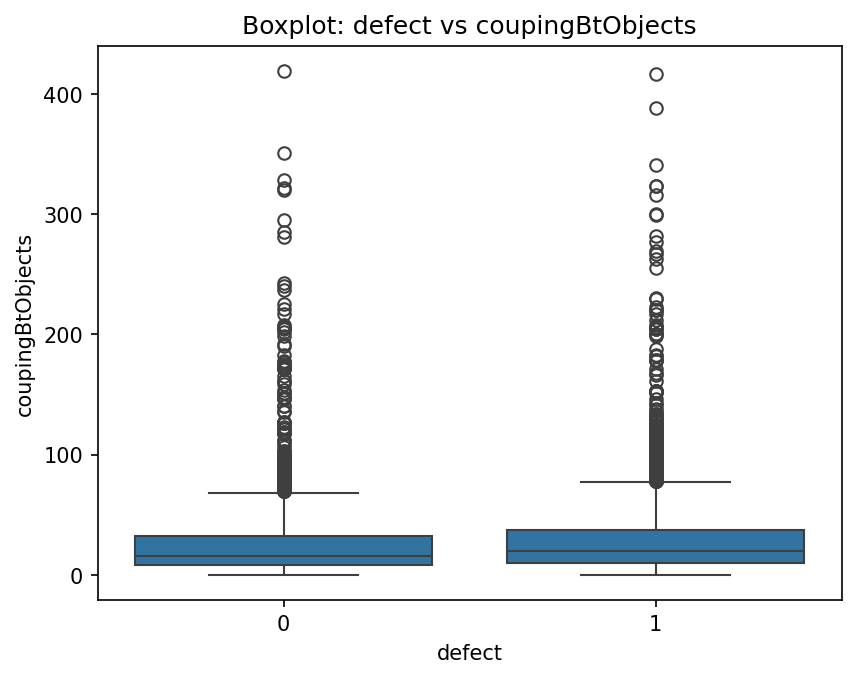

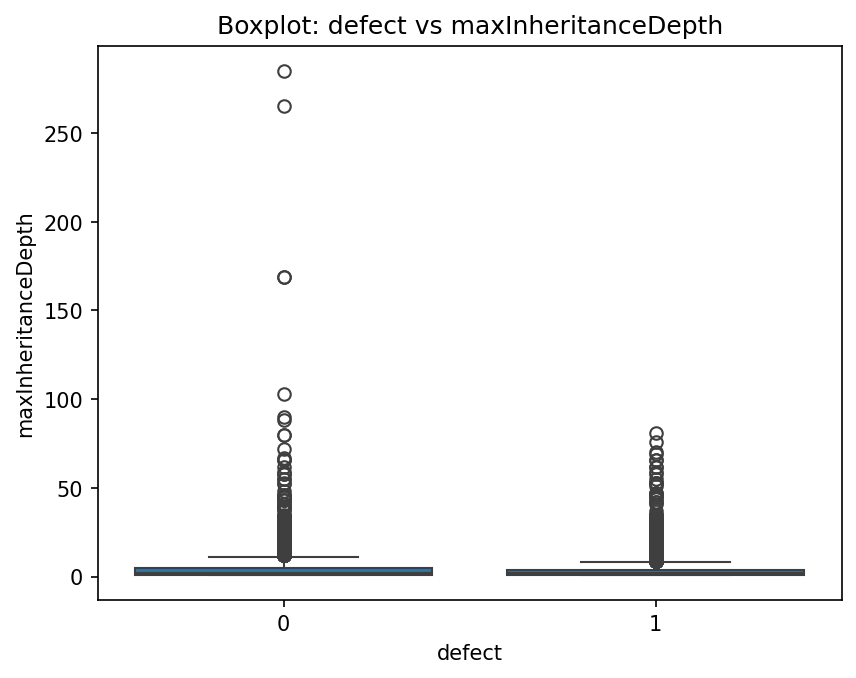

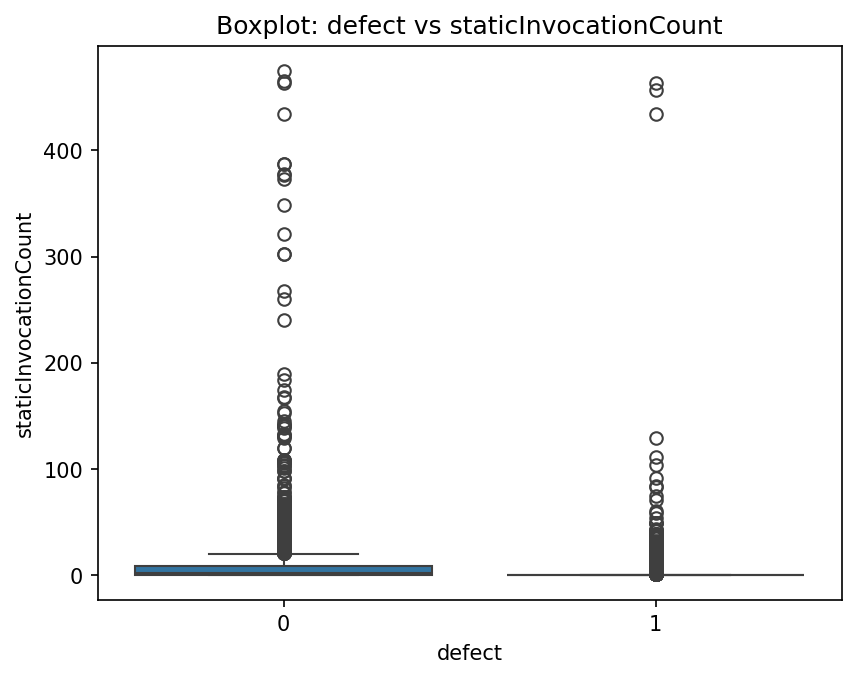

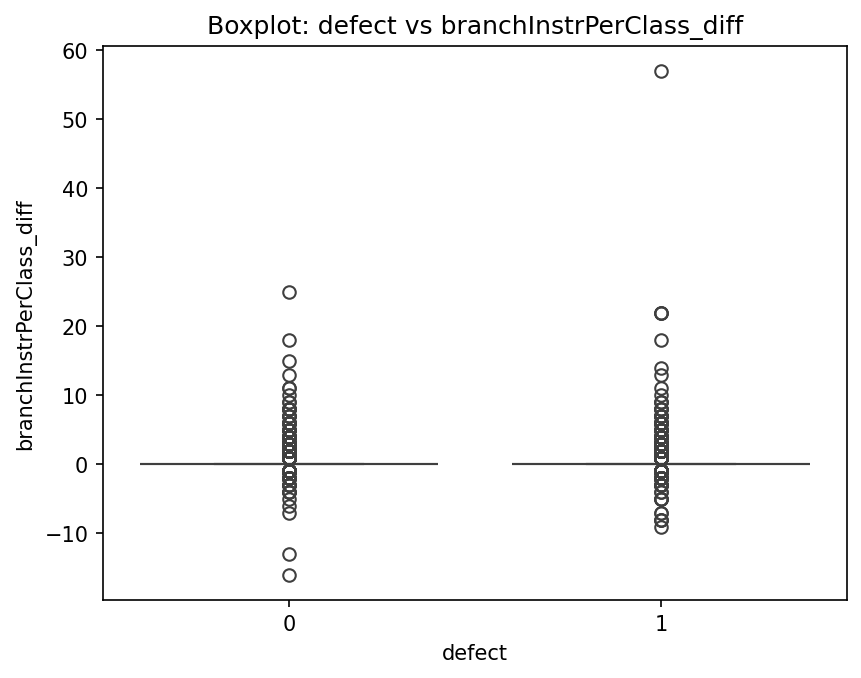

In [28]:
for col_index in low_p_values:
    create_boxplot(metrics_dataframe, DEFECT_COL, INPUT_COLUMNS[col_index])

### Analyzing Violin Plots

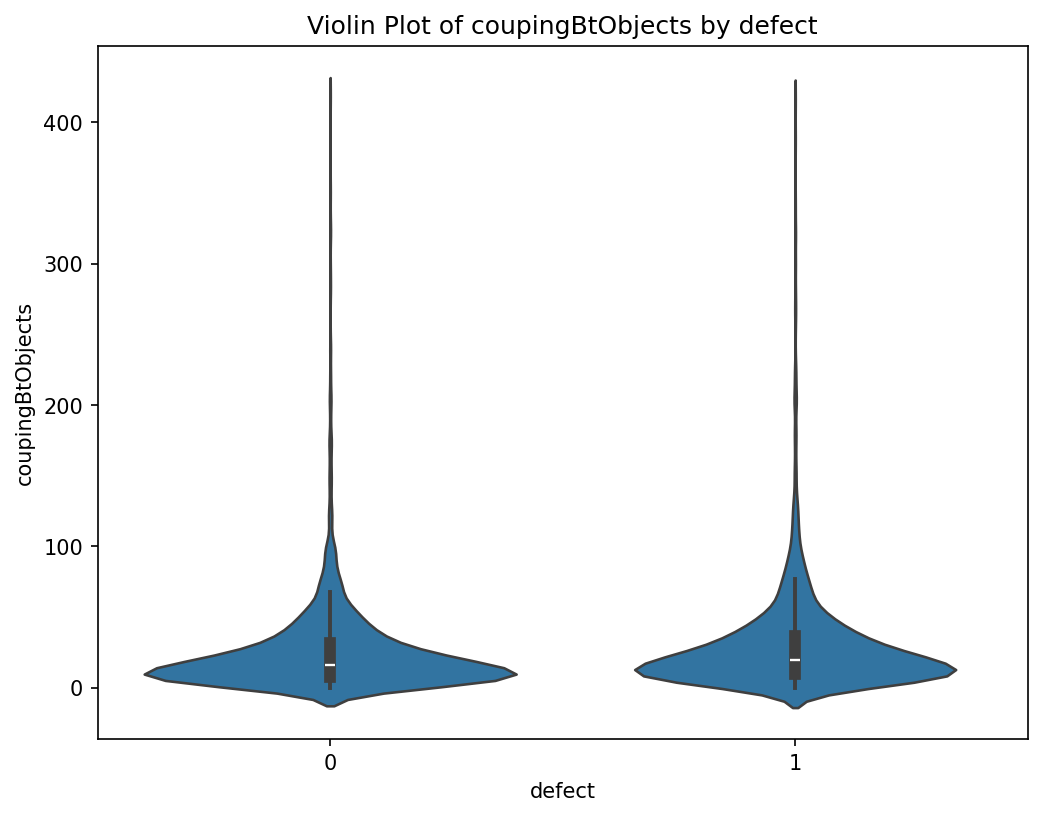

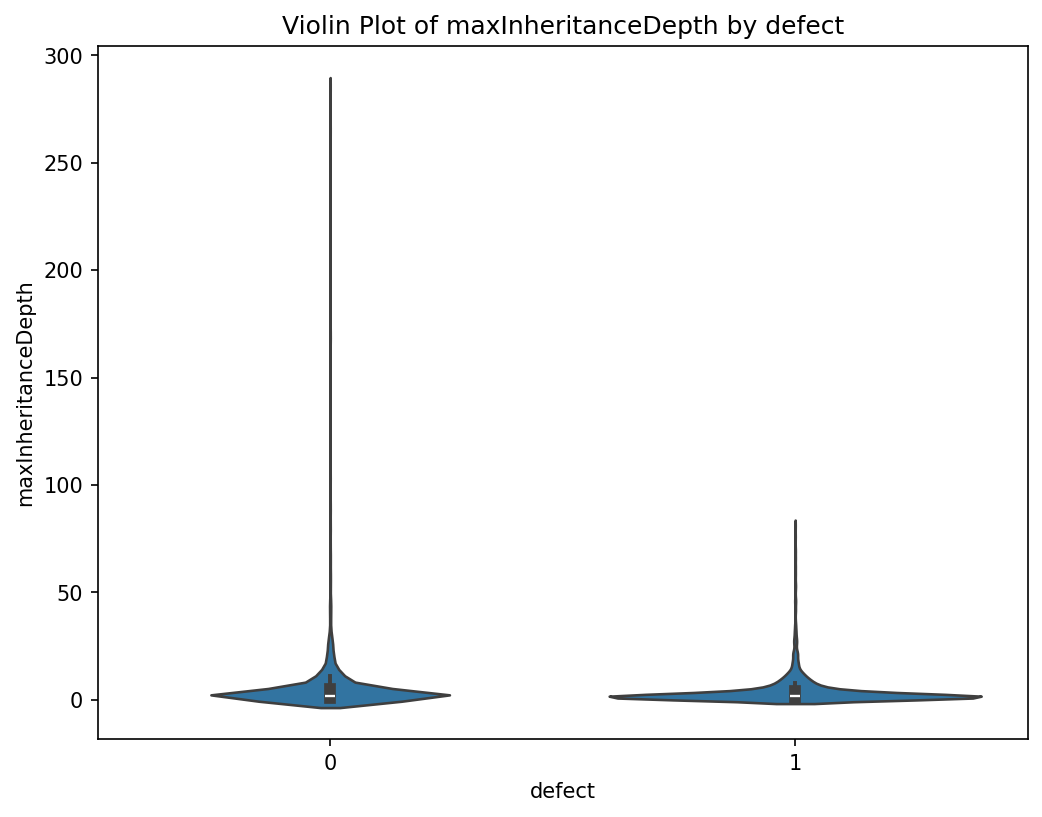

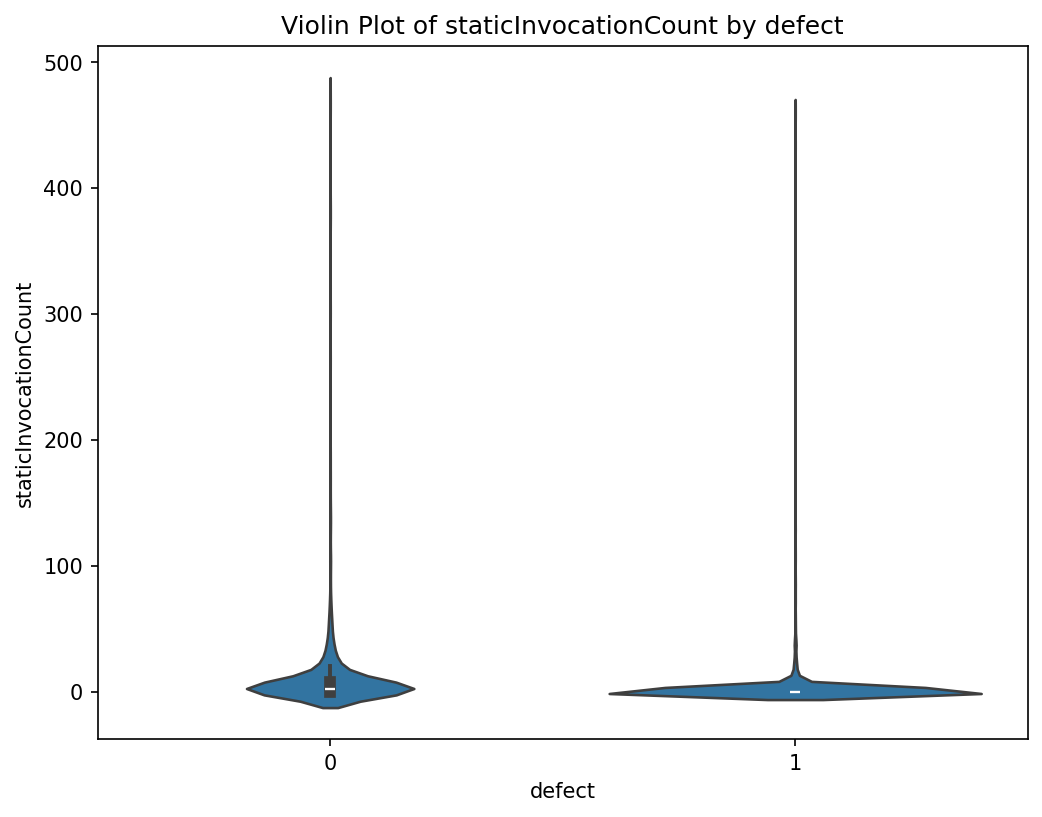

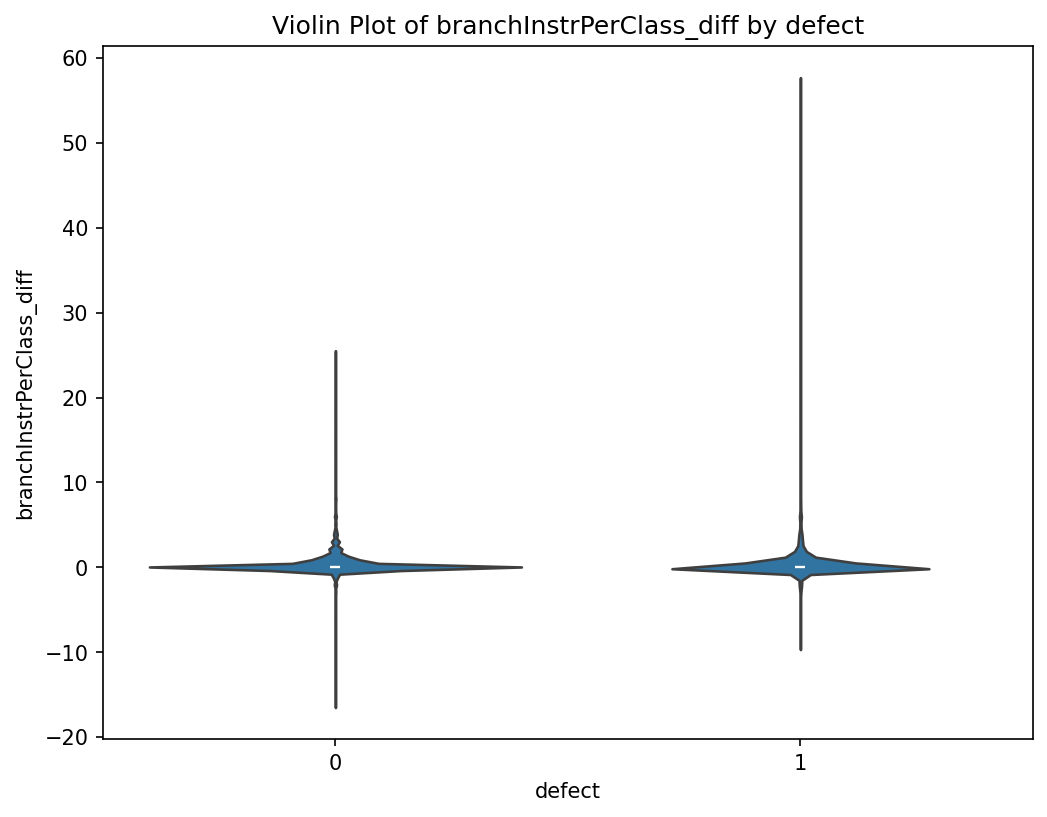

In [29]:
for col_index in low_p_values:
    create_violin_plot(metrics_dataframe, DEFECT_COL, INPUT_COLUMNS[col_index])

## Experimenting with a Decision Tree

In [30]:
import json
import os

TEMP_DATA_FILE = 'data.json'

ccp_value_accuracy_record = {}
if os.path.exists(TEMP_DATA_FILE):
    with open(TEMP_DATA_FILE, 'r') as json_file:
        ccp_value_accuracy_record = json.load(json_file)


In [31]:
defect_label_encoder = LabelEncoder()
defect_label_encoder.fit(metrics_dataframe[DEFECT_COL].values)

print(defect_label_encoder.classes_)

defect_encoded_labels = defect_label_encoder.fit_transform(metrics_dataframe[DEFECT_COL].values)

[0 1]


In [32]:
X_train, X_test, y_train, y_test = train_test_split(metrics_dataframe[INPUT_COLUMNS], defect_encoded_labels, test_size=0.25)

In [33]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, y_train)

y_test_pred = dt_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Testing Accuracy: {test_accuracy:.2%}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.2%}")

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")

if ccp_value_accuracy_record['0'] is None:
    ccp_value_accuracy_record['0'] = test_accuracy
elif ccp_value_accuracy_record['0'] < test_accuracy:
    ccp_value_accuracy_record['0'] = test_accuracy

Testing Accuracy: 65.43%
Balanced Accuracy: 65.43%

Confusion Matrix:
[[511 245]
 [278 479]]


In [34]:
dot_data = export_graphviz(dt_classifier,
                           feature_names=INPUT_COLUMNS,
                           proportion=True,
                           precision=2,
                           rounded=True,
                           class_names=['0', '1'],
                           impurity=False,
                           leaves_parallel=True)
graph = Source(dot_data)
graph

KeyboardInterrupt: 

In [ ]:
graph.render('output_graph-base.png', format='png', cleanup=True)

In [35]:
ccp_alpha = 0.0008

dt_classifier = DecisionTreeClassifier(ccp_alpha=ccp_alpha)

dt_classifier.fit(X_train, y_train)

y_test_pred = dt_classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Testing Accuracy: {test_accuracy:.2%}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred):.2%}")

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_test_pred)}")

if str(ccp_alpha) not in ccp_value_accuracy_record:
    ccp_value_accuracy_record[str(ccp_alpha)] = test_accuracy
elif ccp_value_accuracy_record[str(ccp_alpha)] < test_accuracy:
    ccp_value_accuracy_record[str(ccp_alpha)] = test_accuracy

Testing Accuracy: 77.66%
Balanced Accuracy: 77.66%

Confusion Matrix:
[[558 198]
 [140 617]]


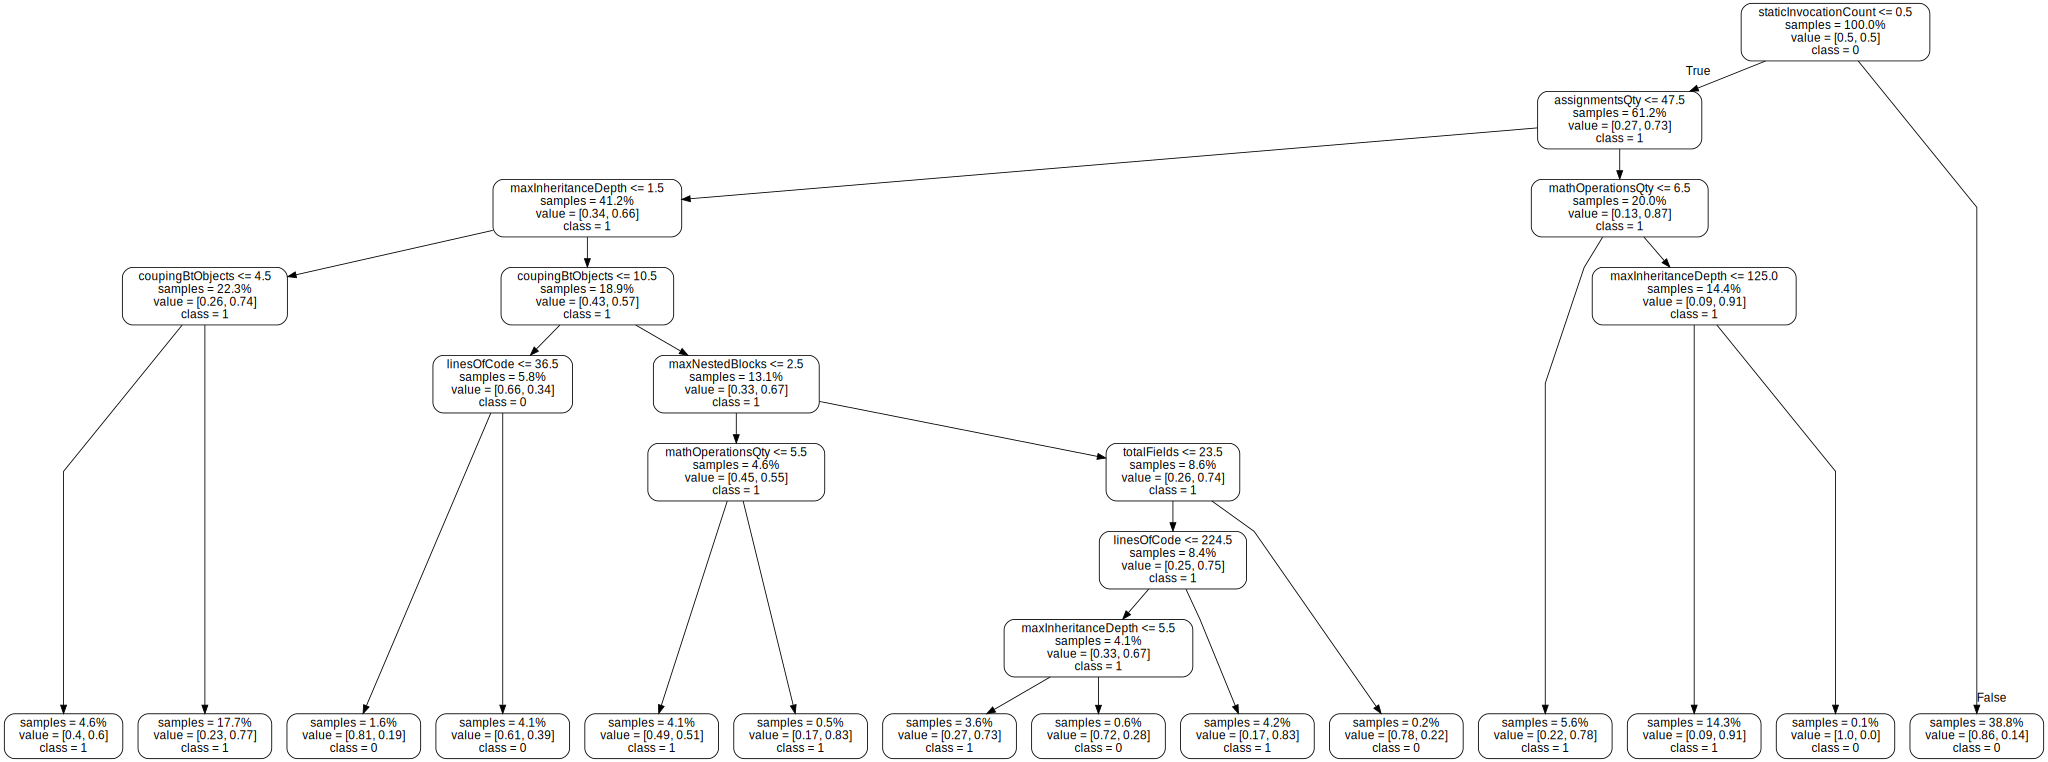

In [36]:
dot_data = export_graphviz(dt_classifier,
                           feature_names=INPUT_COLUMNS,
                           proportion=True,
                           precision=2,
                           rounded=True,
                           class_names=['0', '1'],
                           impurity=False,
                           leaves_parallel=True)
graph = Source(dot_data)
graph

In [37]:
graph.render(f'output_graph-{ccp_alpha}', format='png', cleanup=True)

'output_graph-0.0008.png'

In [38]:
for k, v in ccp_value_accuracy_record.items():
    print(f'{k}: {v:.2%}')

0.1: 78.12%
0.01: 78.12%
0.001: 79.44%
0.0001: 62.52%
0.005: 78.45%
0.002: 79.11%
0.0009: 79.44%
0.0008: 79.78%
0.00086: 78.45%
0: 65.43%


In [39]:
with open(TEMP_DATA_FILE, "w") as json_file:
    json.dump(ccp_value_accuracy_record, json_file, indent=2)

Random Forest Testing Accuracy: 73.63%
Random Forest Balanced Accuracy: 73.63%

Confusion Matrix:
[[534 222]
 [177 580]]


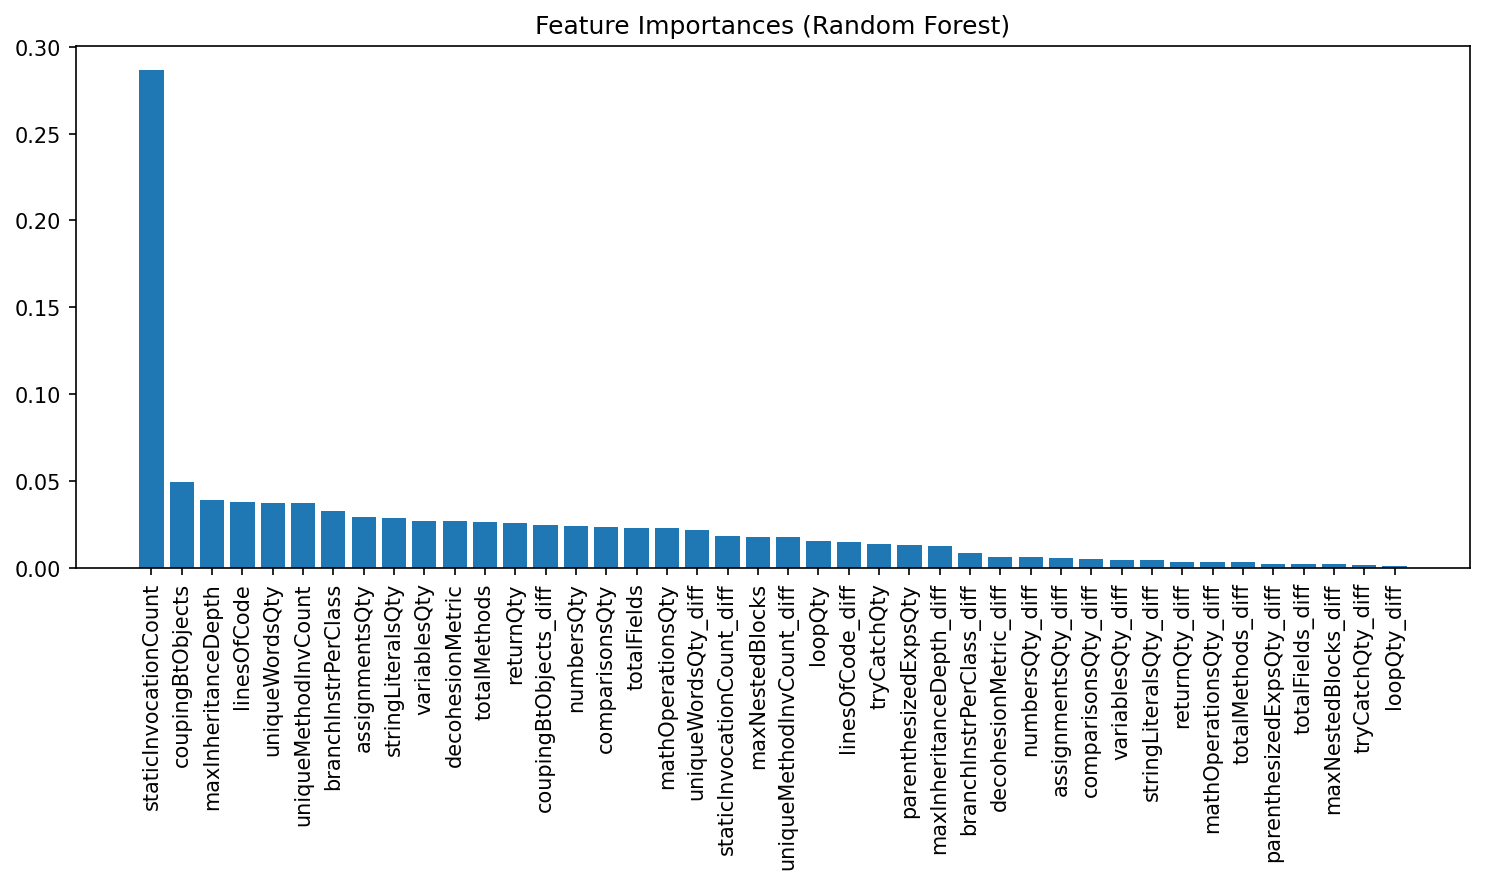

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred_rf = rf_classifier.predict(X_test)

# Evaluate the Random Forest model
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_test_pred_rf)

print(f"Random Forest Testing Accuracy: {rf_test_accuracy:.2%}")
print(f"Random Forest Balanced Accuracy: {rf_balanced_accuracy:.2%}")
print(f"\nConfusion Matrix:\n{rf_confusion_matrix}")

# Feature Importance Visualization
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [INPUT_COLUMNS[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


MLP Testing Accuracy: 70.19%


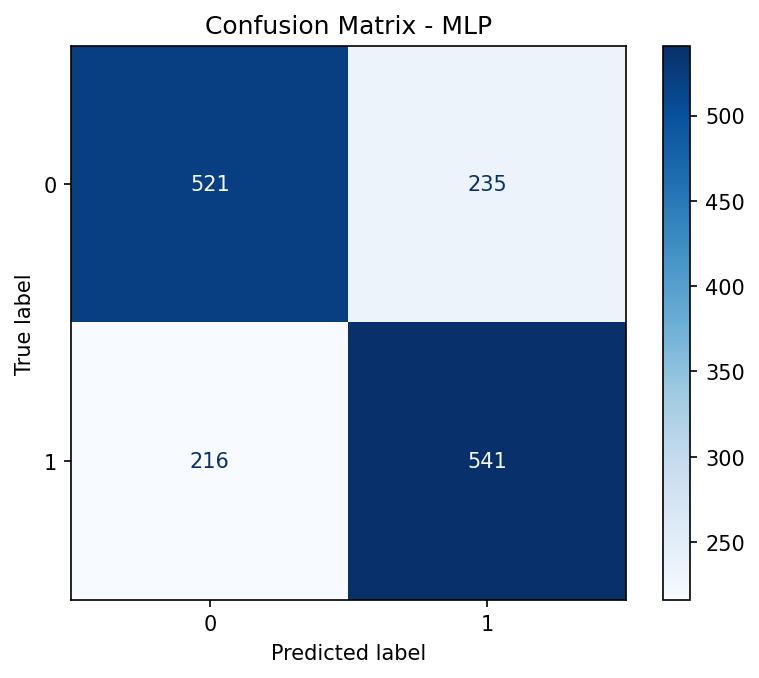

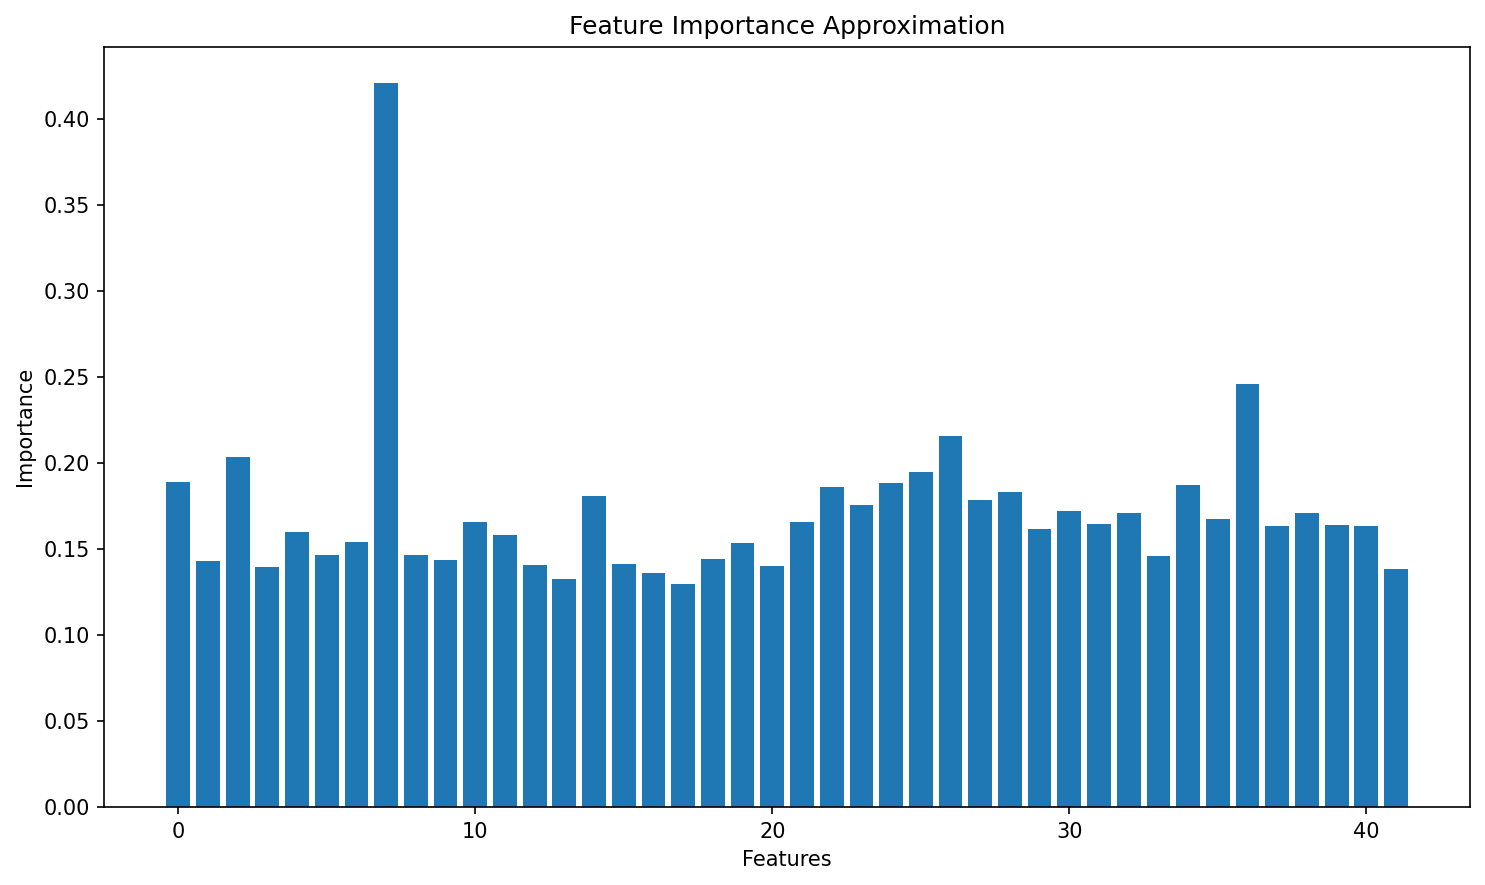

In [41]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers with 64 and 32 neurons
    activation='relu',
    solver='adam',
    alpha=0.0001,  # L2 regularization term
    max_iter=200,  # Number of epochs
    random_state=42
)

# Train the model
mlp_model.fit(X_train_scaled, y_train)

# Make predictions
y_test_pred_mlp = mlp_model.predict(X_test_scaled)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred_mlp)
print(f"MLP Testing Accuracy: {test_accuracy:.2%}")

# Plot the confusion matrix
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
ConfusionMatrixDisplay(cm_mlp).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - MLP')
plt.show()

# Plot feature importance (not directly available, but you can approximate using weights)
feature_importance = abs(mlp_model.coefs_[0]).mean(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance Approximation')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


## 

2024-12-19 15:47:39.934418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 15:47:39.941426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 15:47:39.948219: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 15:47:39.958839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734644859.972928   20142 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734644859.97

Epoch 1/50


/home/pi/csc5610/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-19 15:47:42.496270: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5166 - loss: 0.7287 - val_accuracy: 0.5393 - val_loss: 0.6905
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5432 - loss: 0.6956 - val_accuracy: 0.6239 - val_loss: 0.6751
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6019 - loss: 0.6797 - val_accuracy: 0.6041 - val_loss: 0.6597
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6162 - loss: 0.6588 - val_accuracy: 0.6365 - val_loss: 0.6425
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.6370 - val_accuracy: 0.6913 - val_loss: 0.6231
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6525 - loss: 0.6399 - val_accuracy: 0.7052 - val_loss: 0.6067
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 0.6242 - val_accuracy: 0.6867 - val_loss: 0.6067
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6877 - loss: 0.5996 - val_accuracy: 0.7079 - val_

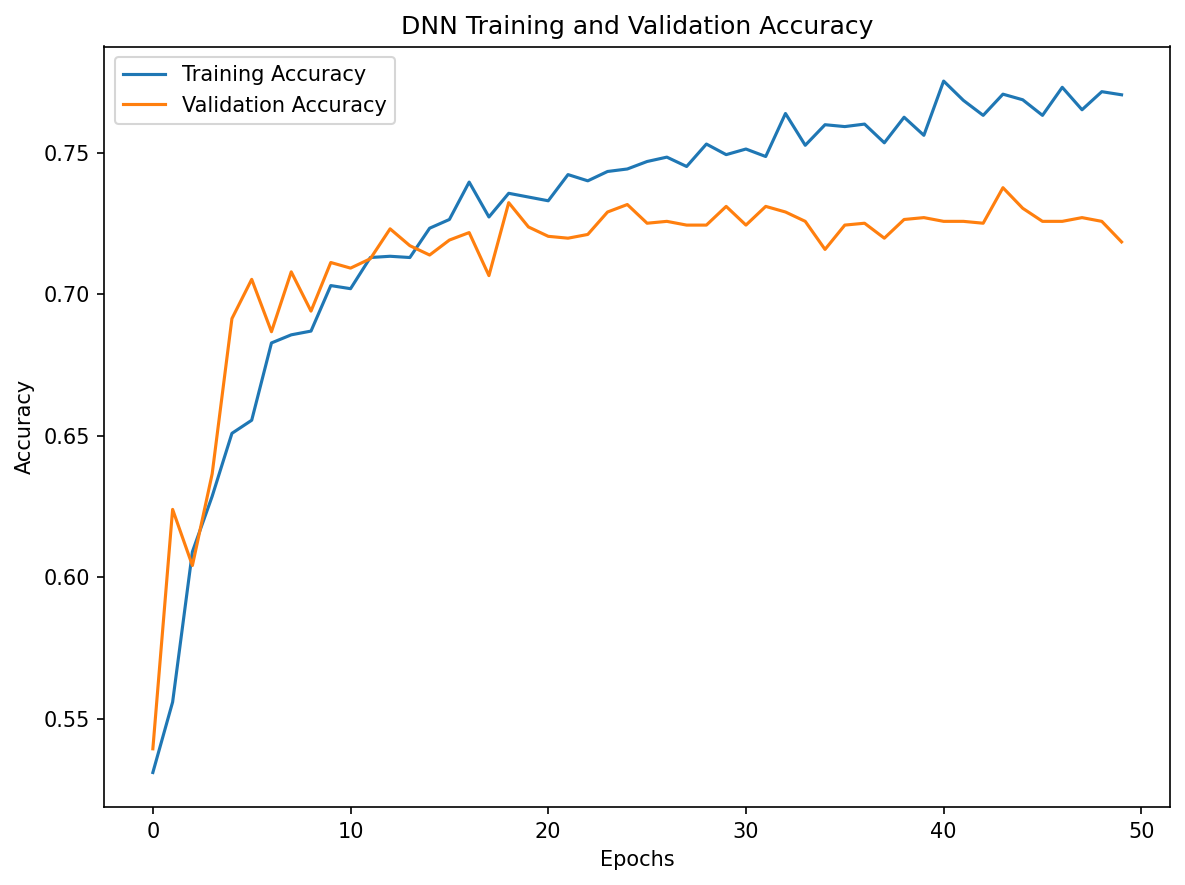

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


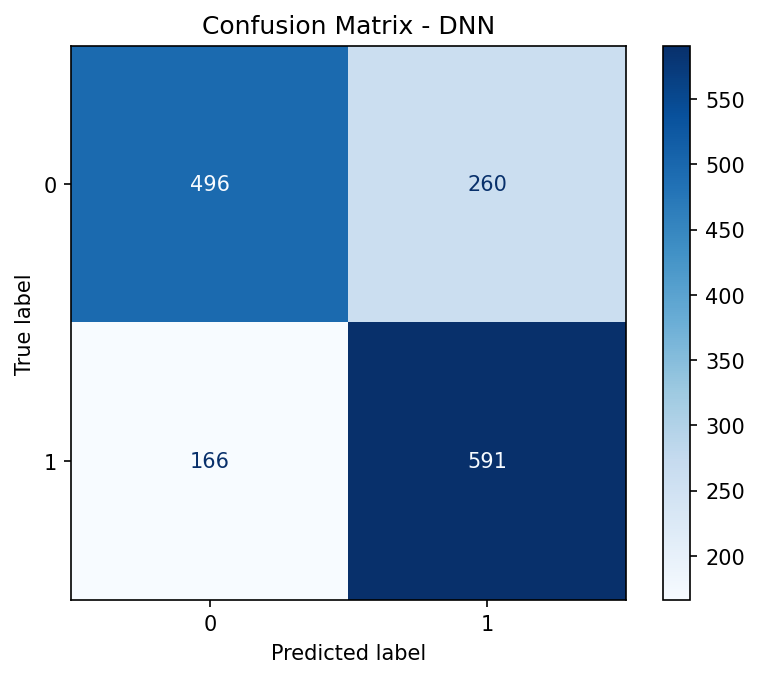

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the DNN model
dnn_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
dnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the DNN model
history = dnn_model.fit(X_train_scaled, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_test_scaled, y_test),
                        verbose=1)

# Evaluate the model
test_loss, test_accuracy = dnn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"DNN Testing Accuracy: {test_accuracy:.2%}")

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred_dnn = (dnn_model.predict(X_test_scaled) > 0.5).astype("int32")
cm_dnn = confusion_matrix(y_test, y_test_pred_dnn)

ConfusionMatrixDisplay(cm_dnn).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - DNN')
plt.show()


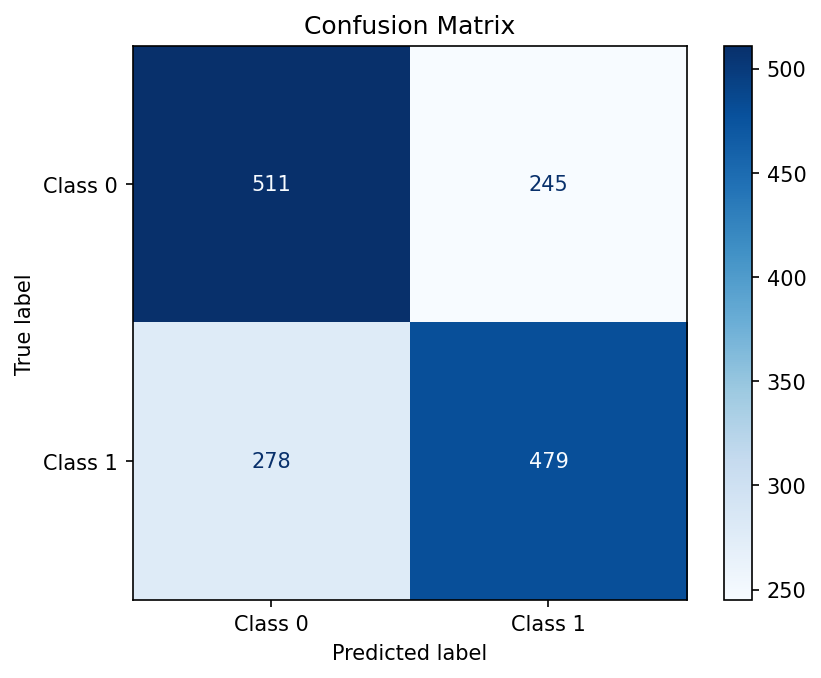

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix data
conf_matrix = np.array([[511, 245], [278, 479]])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()
